In [40]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from skmultiflow.drift_detection import ADWIN

In [41]:
housing_dataset = pd.read_csv('housing.csv')
housing_dataset.dropna(inplace=True)
housing_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Preparing data
Make it look like a Gaussion Bell Curve

In [42]:
dataset = housing_dataset.copy()
dataset['total_rooms'] = np.log(dataset['total_rooms'] + 1 )
dataset['total_bedrooms'] = np.log(dataset['total_bedrooms'] + 1 )
dataset['population'] = np.log(dataset['population'] + 1 )
dataset['households'] = np.log(dataset['households'] + 1 )

Turn Ocean Proximity into Numerical Attribute

In [43]:
dataset = dataset.join(pd.get_dummies(dataset.ocean_proximity)).drop(['ocean_proximity'], axis=1)

In [44]:
X = dataset.drop(['median_house_value'], axis=1)
y = dataset['median_house_value']

# Drift Detection

## Kolmonogorov-Smirnov (K-S) Test
A test used for detecting whether two samples come from the same distribution. This way we can detect a drift in feature's distribution(only for continuous distribution) or target drift. 

We are gonna use it to see the difference in distributions of target variable for different values of ocean_proximity. We want to check whether the distribution of the price of houses changes depending on the distance to the ocean.

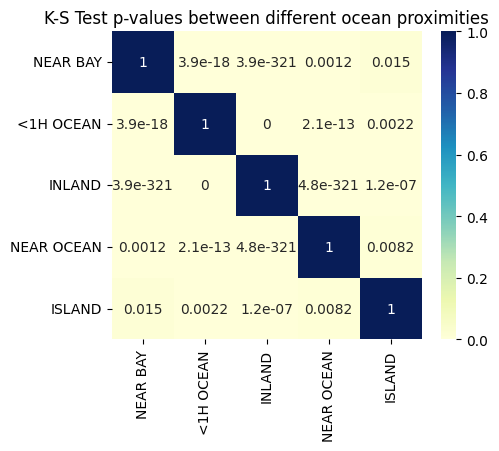

In [45]:
# Checking how different are target distributions for different ocean proximity
ocean_proximities = housing_dataset.ocean_proximity.unique()
ocean_proximities_datasets = [housing_dataset[housing_dataset.ocean_proximity == ocean_proximity].median_house_value for ocean_proximity in ocean_proximities]

size = len(ocean_proximities)
p_values_matrix = np.zeros((size, size))
# Compute p-values for each pair of distributions
for i in range(size):
    for j in range(size):
        result = stats.kstest(ocean_proximities_datasets[i], ocean_proximities_datasets[j]) # The null hypothesis is that the two distributions are identical
        p_values_matrix[i, j] = result.pvalue

# Create heatmap of p-values
plt.figure(figsize=(5, 4))
sns.heatmap(p_values_matrix, annot=True, cmap="YlGnBu", xticklabels=ocean_proximities, yticklabels=ocean_proximities)
plt.title("K-S Test p-values between different ocean proximities")
plt.show()

Clearly distributions of target values are different for different ocean proximity, since the p-value is lower than 3% for all of the pairs 

##  ADaptive WINdowing Drift Detection

This algorithm detects concept drift in the stream of data. For that we use our data sorted by longitude.

### Testing sorted data's target value for data drift

In [46]:
ddm = ADWIN()

detected_changes = []

for index, value  in y.items():
    ddm.add_element(value)
    if ddm.detected_change():
        detected_changes.append(index)
        #print('Change has been detected in data: ' + str(value) + ' - of index: ' + str(index))

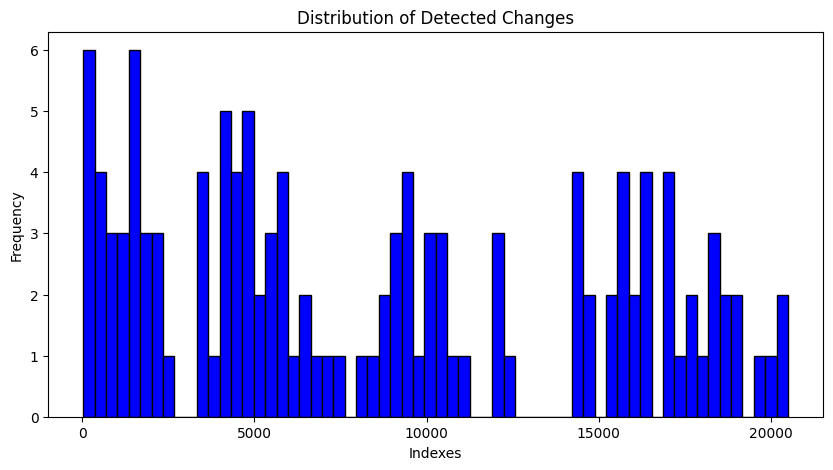

In [47]:
def plot_index_distribution(indexes):
    plt.figure(figsize=(10, 5))
    plt.hist(indexes, bins=len(set(indexes))//2, color='blue', edgecolor='black')
    plt.title('Distribution of Detected Changes')
    plt.xlabel('Indexes')
    plt.ylabel('Frequency')
    plt.show()

plot_index_distribution(detected_changes)

The algorithm detects lots of changes in the distribution, hence we can conclude that the distribution of house prices changes as we move with the location from south to north.

### Testing if the model can deal with such data drift

For that we devide our data into two parts: north and south and we train the model only on one part and then we evaluate the model on the other part.

In [48]:
# Proportion is for diving into evaluation and train/test
def get_stream_data_model(X, y, proportion = 0.5, logging = 1): 

    midpoint = int(len(X)*proportion)

    # Data for training and testing
    X_test_and_train = X.iloc[:midpoint]
    y_test_and_train = y.iloc[:midpoint]

    # Data that comes in a stream for evaluation
    X_stream = X.iloc[midpoint:]
    y_stream = y.iloc[midpoint:]

    X_train, X_test, y_train, y_test = train_test_split(X_test_and_train, y_test_and_train, test_size=0.3, random_state=0)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_stream_scaled = scaler.transform(X_stream)

    forest = RandomForestRegressor( random_state=0) 

    param_grid = {
        'n_estimators': [30, 50, 100],
        'max_features': [6, 8, 12],
        "min_samples_split": [2, 4, 6, 8],
    }

    grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = logging, n_jobs = -1)
    grid_search.fit(X_train_scaled, y_train)

    # Score on test data 
    test_score = grid_search.best_estimator_.score(X_test_scaled, y_test)

    if(logging > 0):
        print("Test score = " + str(test_score))

    return grid_search.best_estimator_ , X_stream_scaled, y_stream


In [49]:
# Getting a model trained on first half of the stream in order to evaluate it on the other half of the stream
ADWIN_best_forest, ADWIN_X_stream, ADWIN_y_stream = get_stream_data_model(X,y,logging=1, proportion=0.5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Test score = 0.8534904788893112


In [53]:
# Evaluating the model on the other half of the stream
print("Evaluation score = " + str(ADWIN_best_forest.score(ADWIN_X_stream, ADWIN_y_stream)))

Evaluation score = 0.5699552939673751


The results are much worse than desirable. This model doesn't adapt well to this change in data.

### Testing whether adding feature engineering helps the model
Let's see the same experiment but with feature engineering.

In [51]:
X_feature_engineering = X.copy()
X_feature_engineering['bedroom_ratio'] = X['total_bedrooms'] / X['total_rooms']
X_feature_engineering['households_rooms'] = X['total_rooms'] / X['households']

In [52]:
# Getting a model trained on first half of the stream in order to evaluate it on the other half of the stream
ADWIN_best_forest_feature_engineering, ADWIN_X_feature_engineering_stream, ADWIN_y_feature_engineering_stream = get_stream_data_model(X_feature_engineering,y,logging=1, proportion=0.5)
print("Evaluation score = " + str(ADWIN_best_forest_feature_engineering.score(ADWIN_X_feature_engineering_stream, ADWIN_y_feature_engineering_stream)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Test score = 0.8496711726061685
Evaluation score = 0.6064177788594036


The results are slightly better but still far from desirable.